## Notebook 3: 

This is an IPython notebook. Most of the code is composed of bash scripts, indicated by %%bash at the top of the cell, otherwise it is IPython code. This notebook includes code to download, assemble and analyze a published RADseq data set.

In [2]:
### Notebook 3
### Data set 3 (American oaks)
### Authors: Eaton et al. (2015)
### Data Location: NCBI SRA SRP055977

## Download the sequence data
Sequence data for this study are archived on the NCBI sequence read archive (SRA). Below I read in SraRunTable.txt for this project which contains all of the information we need to download the data. 

+ Project SRA: SRP055977
+ BioProject ID: PRJNA277574
+ Biosample numbers: SAMN03394519 - SAMN03394561
+ Runs: SRR1915524 -- SRR1915566
+ SRA link: http://trace.ncbi.nlm.nih.gov/Traces/study/?acc=SRP055977

In [45]:
%%bash
## make a new directory for this analysis
mkdir -p empirical_3/fastq/

In [46]:
## IPython code
import pandas as pd
import urllib2
import os

## open the SRA run table from github url
url = "https://raw.githubusercontent.com/"+\
      "dereneaton/RADmissing/master/empirical_3_SraRunTable.txt"
intable = urllib2.urlopen(url)
indata = pd.read_table(intable, sep="\t")

## print first few rows
print indata.head()

    BioSample_s Library_Name_s  MBases_l  MBytes_l           Organism_s  \
0  SAMN03394519          AR_re       366       240    Quercus arizonica   
1  SAMN03394520      BJSL25_re       484       313   Quercus brandegeei   
2  SAMN03394521      BJVL19_re       427       275   Quercus brandegeei   
3  SAMN03394522          CH_re       411       268  Quercus chrysolepis   
4  SAMN03394523     CRL0001_re       339       220     Quercus oleoides   

  ReleaseDate_s       Run_s SRA_Sample_s Sample_Name_s  \
0  Mar 13, 2015  SRR1915524    SRS868426         AR_re   
1  Mar 13, 2015  SRR1915525    SRS874263     BJSL25_re   
2  Mar 13, 2015  SRR1915526    SRS874262     BJVL19_re   
3  Mar 13, 2015  SRR1915527    SRS874261         CH_re   
4  Mar 13, 2015  SRR1915528    SRS874260    CRL0001_re   

                                  geo_loc_name_s Assay_Type_s  AssemblyName_s  \
0              USA: UMN Greenhouse, St. Paul, MN          WGS  <not provided>   
1         Mexico: Sierra la Laguna, Ba

In [47]:
def wget_download(SRR, outdir, outname):
    """ Python function to get sra data from ncbi and write to
    outdir with a new name using bash call wget """
    
    ## get output name
    output = os.path.join(outdir, outname+".sra")
    
    ## create a call string 
    call = "wget -q -r -nH --cut-dirs=9 -O "+output+" "+\
           "ftp://ftp-trace.ncbi.nlm.nih.gov/"+\
           "sra/sra-instant/reads/ByRun/sra/SRR/"+\
           "{}/{}/{}.sra;".format(SRR[:6], SRR, SRR)
        
    ## call bash script
    ! $call 

Here we pass the SRR number and the sample name to the `wget_download` function so that the files are saved with their sample names. 

In [48]:
for ID, SRR in zip(indata.Library_Name_s, indata.Run_s):
    wget_download(SRR, "empirical_3/fastq/", ID)

In [49]:
%%bash
## convert sra files to fastq using fastq-dump tool
## output as gzipped into the fastq directory
fastq-dump --gzip -O empirical_3/fastq/  empirical_3/fastq/*.sra

## remove .sra files
rm empirical_3/fastq/*.sra

Read 4046890 spots for empirical_3/fastq/AR_re.sra
Written 4046890 spots for empirical_3/fastq/AR_re.sra
Read 931926 spots for empirical_3/fastq/BJSB3_v.sra
Written 931926 spots for empirical_3/fastq/BJSB3_v.sra
Read 5352627 spots for empirical_3/fastq/BJSL25_re.sra
Written 5352627 spots for empirical_3/fastq/BJSL25_re.sra
Read 969575 spots for empirical_3/fastq/BJSL25_v.sra
Written 969575 spots for empirical_3/fastq/BJSL25_v.sra
Read 4715624 spots for empirical_3/fastq/BJVL19_re.sra
Written 4715624 spots for empirical_3/fastq/BJVL19_re.sra
Read 817443 spots for empirical_3/fastq/BJVL19_v.sra
Written 817443 spots for empirical_3/fastq/BJVL19_v.sra
Read 849191 spots for empirical_3/fastq/BZBB1_v.sra
Written 849191 spots for empirical_3/fastq/BZBB1_v.sra
Read 4539385 spots for empirical_3/fastq/CH_re.sra
Written 4539385 spots for empirical_3/fastq/CH_re.sra
Read 3742953 spots for empirical_3/fastq/CRL0001_re.sra
Written 3742953 spots for empirical_3/fastq/CRL0001_re.sra
Read 1012884 spot

This study includes several re-sequenced individuals. We combine them before beginning the analysis.

In [50]:
##IPython code
import glob

taxa = [i.split("/")[-1].split('_')[0] for i in glob.glob("empirical_3/fastq/*.gz")]
for taxon in set(taxa):
    if taxa.count(taxon) > 1:
        print taxon, "merged"
        
        ## merge replicate files
        ! cat empirical_3/fastq/$taxon\_v.fastq.gz \
              empirical_3/fastq/$taxon\_re.fastq.gz \
            > empirical_3/fastq/$taxon\_me.fastq.gz
            
        ## remove ind replicate files
        ! rm empirical_3/fastq/$taxon\_v.fastq.gz
        ! rm empirical_3/fastq/$taxon\_re.fastq.gz

BJVL19 merged
CRL0001 merged
BJSL25 merged
FLBA140 merged
FLAB109 merged
CRL0030 merged
FLSF54 merged


## Make a params file

In [51]:
%%bash
pyrad --version

pyRAD 3.0.63


In [52]:
%%bash
## remove old params file if it exists
rm params.txt 

## create a new default params file
pyrad -n 

	new params.txt file created


In [21]:
%%bash
## substitute new parameters into file
sed -i '/## 1. /c\empirical_3/           ## 1. working directory ' params.txt
sed -i '/## 6. /c\TGCAG                  ## 6. cutters ' params.txt
sed -i '/## 7. /c\20                     ## 7. N processors      ' params.txt
sed -i '/## 9. /c\6                      ## 9. NQual             ' params.txt
sed -i '/## 10./c\.85                    ## 10. clust threshold  ' params.txt
sed -i '/## 12./c\4                      ## 12. MinCov           ' params.txt
sed -i '/## 13./c\10                     ## 13. maxSH            ' params.txt
sed -i '/## 14./c\empirical_3_m4         ## 14. output name      ' params.txt
sed -i '/## 18./c\empirical_3/fastq/*.gz ## 18. data location    ' params.txt
sed -i '/## 29./c\2,2                    ## 29. trim overhang    ' params.txt
sed -i '/## 30./c\p,n,s                  ## 30. output formats   ' params.txt

In [22]:
cat params.txt

==** parameter inputs for pyRAD version 3.0.63  **======================== affected step ==
empirical_3/           ## 1. working directory 
./*.fastq.gz              ## 2. Loc. of non-demultiplexed files (if not line 18)  (s1)
./*.barcodes              ## 3. Loc. of barcode file (if not line 18)             (s1)
vsearch                   ## 4. command (or path) to call vsearch (or usearch)    (s3,s6)
muscle                    ## 5. command (or path) to call muscle                  (s3,s7)
TGCAG                  ## 6. cutters 
20                     ## 7. N processors      
6                         ## 8. Mindepth: min coverage for a cluster              (s4,s5)
6                      ## 9. NQual             
.85                    ## 10. clust threshold  
rad                       ## 11. Datatype: rad,gbs,pairgbs,pairddrad,(others:see docs)(all)
4                      ## 12. MinCov           
10                     ## 13. maxSH            
empirical_3_m4         ## 14. output name     

## Assemble in _pyrad_


In [ ]:
%%bash
pyrad -p params.txt -s 234567 >> log.txt 2>&1  

In [23]:
%%bash
sed -i '/## 12./c\2                      ## 12. MinCov           ' params.txt
sed -i '/## 14./c\empirical_3_m2         ## 14. output name      ' params.txt

In [24]:
%%bash
pyrad -p params.txt -s 7 >> log.txt 2>&1

## Results
We are interested in the relationship between the amount of input (raw) data between any two samples, the average coverage they recover when clustered together, and the phylogenetic distances separating samples.  

#### Raw data amounts
The average number of raw reads per sample is 1.36M.

In [2]:
## read in the data
s2dat = pd.read_table("empirical_3/stats/s2.rawedit.txt", header=0, nrows=36)

## print summary stats
print s2dat["passed.total"].describe()

## find which sample has the most raw data
maxraw = s2dat["passed.total"].max()
print "\nmost raw data in sample:"
print s2dat['sample '][s2dat['passed.total']==maxraw]

count         36.000000
mean     1955564.750000
std      1594388.931033
min        84505.000000
25%       806803.750000
50%      1050559.000000
75%      3425603.250000
max      5829065.000000
Name: passed.total, dtype: float64

most raw data in sample:
2    BJSL25_me
Name: sample , dtype: object


### Look at distributions of coverage
pyrad v.3.0.63 outputs depth information for each sample which I read in here and plot. First let's ask which sample has the highest depth of coverage. The std of coverages is pretty low in this data set compared to several others. 

In [9]:
## read in the s3 results
s3dat = pd.read_table("empirical_3/stats/s3.clusters.txt", header=0, nrows=39)

## print summary stats
print "summary of means\n=================="
print s3dat['dpt.me'].describe()

## print summary stats
print "\nsummary of std\n=================="
print s3dat['dpt.sd'].describe()

## print summary stats
print "\nsummary of proportion lowdepth\n=================="
print pd.Series(1-s3dat['d>5.tot']/s3dat["total"]).describe()

## find which sample has the greatest depth of retained loci
max_hiprop = (s3dat["d>5.tot"]/s3dat["total"]).max()
print "\nhighest coverage in sample:"
print s3dat['taxa'][s3dat['d>5.tot']/s3dat["total"]==max_hiprop]

summary of means
count    36.00000
mean     17.80300
std      13.02276
min       3.31500
25%       9.02300
50%      11.61800
75%      25.41200
max      51.11900
Name: dpt.me, dtype: float64

summary of std
count     36.000000
mean      70.155611
std       59.520107
min        3.718000
25%       28.191000
50%       47.720500
75%       98.996000
max      211.783000
Name: dpt.sd, dtype: float64

summary of proportion lowdepth
count    36.000000
mean      0.427849
std       0.157876
min       0.211693
25%       0.300563
50%       0.440962
75%       0.497383
max       0.860847
dtype: float64

highest coverage in sample:
0    AR_re
Name: taxa, dtype: object


In [11]:
import numpy as np
## print mean and std of coverage for the highest coverage sample
with open("empirical_3/clust.85/AR_re.depths", 'rb') as indat:
    depths = np.array(indat.read().strip().split(","), dtype=int)
    
print depths.mean(), depths.std()

37.41198396 122.321191848


#### Plot the coverage for the sample with highest mean coverage
Green shows the loci that were discarded and orange the loci that were retained. The majority of data were discarded for being too low of coverage. 

In [19]:
import toyplot
import toyplot.svg
import numpy as np

## read in the depth information for this sample
with open("empirical_3/clust.85/AR_re.depths", 'rb') as indat:
    depths = np.array(indat.read().strip().split(","), dtype=int)
    
## make a barplot in Toyplot
canvas = toyplot.Canvas(width=350, height=300)
axes = canvas.axes(xlabel="Depth of coverage (N reads)", 
                   ylabel="N loci", 
                   label="dataset3/sample=AR_re")

## select the loci with depth > 5 (kept)
keeps = depths[depths>5]

## plot kept and discarded loci
edat = np.histogram(depths, range(30)) # density=True)
kdat = np.histogram(keeps, range(30)) #, density=True)
axes.bars(edat)
axes.bars(kdat)

#toyplot.svg.render(canvas, "empirical_3_depthplot.svg")

### Print final stats table

In [25]:
cat empirical_3/stats/empirical_3_m4.stats




90871       ## loci with > minsp containing data
87969       ## loci with > minsp containing data & paralogs removed
87969       ## loci with > minsp containing data & paralogs removed & final filtering

## number of loci recovered in final data set for each taxon.
taxon	nloci
AR_re     	54176
BJSB3_v   	38030
BJSL25_me 	61596
BJVL19_me 	60159
BZBB1_v   	35466
CH_re     	51058
CRL0001_me	62704
CRL0030_me	60181
CUCA4_v   	25875
CUMM5_v   	2520
CUSV6_v   	34898
CUVN10_v  	43516
DO_re     	46865
DU_re     	52925
EN_re     	28342
FLAB109_me	53770
FLBA140_me	59903
FLCK18_v  	35834
FLCK216_v 	33674
FLMO62_v  	37431
FLSA185_v 	29650
FLSF33_v  	35589
FLSF47_v  	37411
FLSF54_me 	60404
FLWO6_v   	35292
HE_re     	42687
HNDA09_v  	43262
LALC2_v   	48666
MXED8_v   	41094
MXGT4_v   	47152
MXSA3017_v	40169
NI_re     	44506
SCCU3_v   	18442
TXGR3_v   	34111
TXMD3_v   	37451
TXWV2_v   	5109


## nloci = number of loci with data for exactly ntaxa
## ntotal = number of loci for which at least ntaxa ha

In [26]:
%%bash
head -n 10 empirical_3/stats/empirical_3_m2.stats




145112      ## loci with > minsp containing data
142210      ## loci with > minsp containing data & paralogs removed
142210      ## loci with > minsp containing data & paralogs removed & final filtering

## number of loci recovered in final data set for each taxon.
taxon	nloci
AR_re     	58912
BJSB3_v   	39297


## Infer ML phylogeny in _raxml_ as an unrooted tree

In [ ]:
%%bash
## raxml argumement w/ ...
raxmlHPC-PTHREADS-AVX -f a -m GTRGAMMA -N 100 -x 12345 -p 12345 -T 20 \
                      -w /home/deren/Documents/RADmissing/empirical_3/ \
                      -n empirical_3_m4 -s empirical_3/outfiles/empirical_3_m4.phy
                      

In [ ]:
%%bash
## raxml argumement w/ ...
raxmlHPC-PTHREADS-AVX -f a -m GTRGAMMA -N 100 -x 12345 -p 12345 -T 20 \
                      -w /home/deren/Documents/RADmissing/empirical_3/ \
                      -n empirical_3_m2 -s empirical_3/outfiles/empirical_3_m2.phy
                      

In [27]:
%%bash
head -n 20 empirical_3/RAxML_info.empirical_3_m4



This is RAxML version 8.0.16 released by Alexandros Stamatakis on March 21 2014.

With greatly appreciated code contributions by:
Andre Aberer      (HITS)
Simon Berger      (HITS)
Alexey Kozlov     (HITS)
Nick Pattengale   (Sandia)
Wayne Pfeiffer    (SDSC)
Akifumi S. Tanabe (NRIFS)
David Dao         (KIT)
Charlie Taylor    (UF)


Alignment has 612971 distinct alignment patterns

Proportion of gaps and completely undetermined characters in this alignment: 53.74%

RAxML rapid bootstrapping and subsequent ML search


In [28]:
%%bash
head -n 20 empirical_3/RAxML_info.empirical_3_m2

head: cannot open ‘empirical_3/RAxML_info.empirical_3_m2’ for reading: No such file or directory


#### Plot the tree in R using `ape`

In [29]:
%load_ext rpy2.ipython

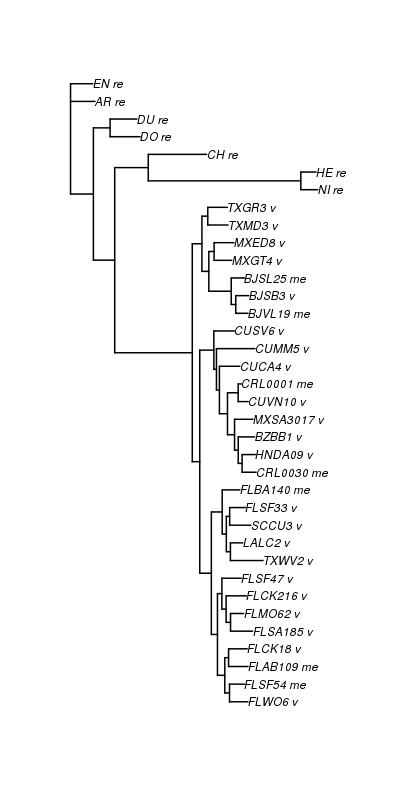

In [30]:
%%R -w 400 -h 800
library(ape)
tre <- read.tree("empirical_3/RAxML_bipartitions.empirical_3")
ltre <- ladderize(tre)
plot(ltre, edge.width=2)

### Meaure phylo distance (GTRgamma distance)

In [33]:
%%R
mean(cophenetic.phylo(ltre))

[1] 0.01793173
